# **MRMS/CCRFCD** Rain-Gauge Data Analysis
---

- Time Period: [2021.01.01-2025.07.25]
- **`TODO`**: describe data-collection methodology in detail
- **`TODO`**: explain format of master-dataframe

### 0. Imports & Magic Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime


ALL_EVENTS_DF = "/playpen/mufan/levi/tianlong-chen-lab/nws-lv-precip-forecasting/ccrfcd-gauge-grids/data/events/2021-01-01_2025-07-25_all_events.csv"

### 1. Whole-Dataset Analysis

In [2]:
df = pd.read_csv(ALL_EVENTS_DF)

# NOTE: filter out extremes
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df['delta_qpe'] > df['delta_qpe'].quantile(0.001)) & (df['delta_qpe'] < df['delta_qpe'].quantile(0.999))
df   = df.loc[mask].copy()
df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,cum_gauge_qpe,cum_mrms_qpe
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937,0.00,0.003937
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000,0.04,0.000000
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000,0.04,0.000000
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811,0.00,0.011811
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748,0.00,0.015748


In [ ]:
print(f"# Data points: {len(df)}")
print(f"# Unique gauges: {len(set(df['station_id']))}")

Total number of data points: 2337407
Number of unique gauges: 223


#### 1.1. Distribution of Events by Date

In [ ]:
dts        = [datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in df['start_time']]
unique_dts = list(set(dts))

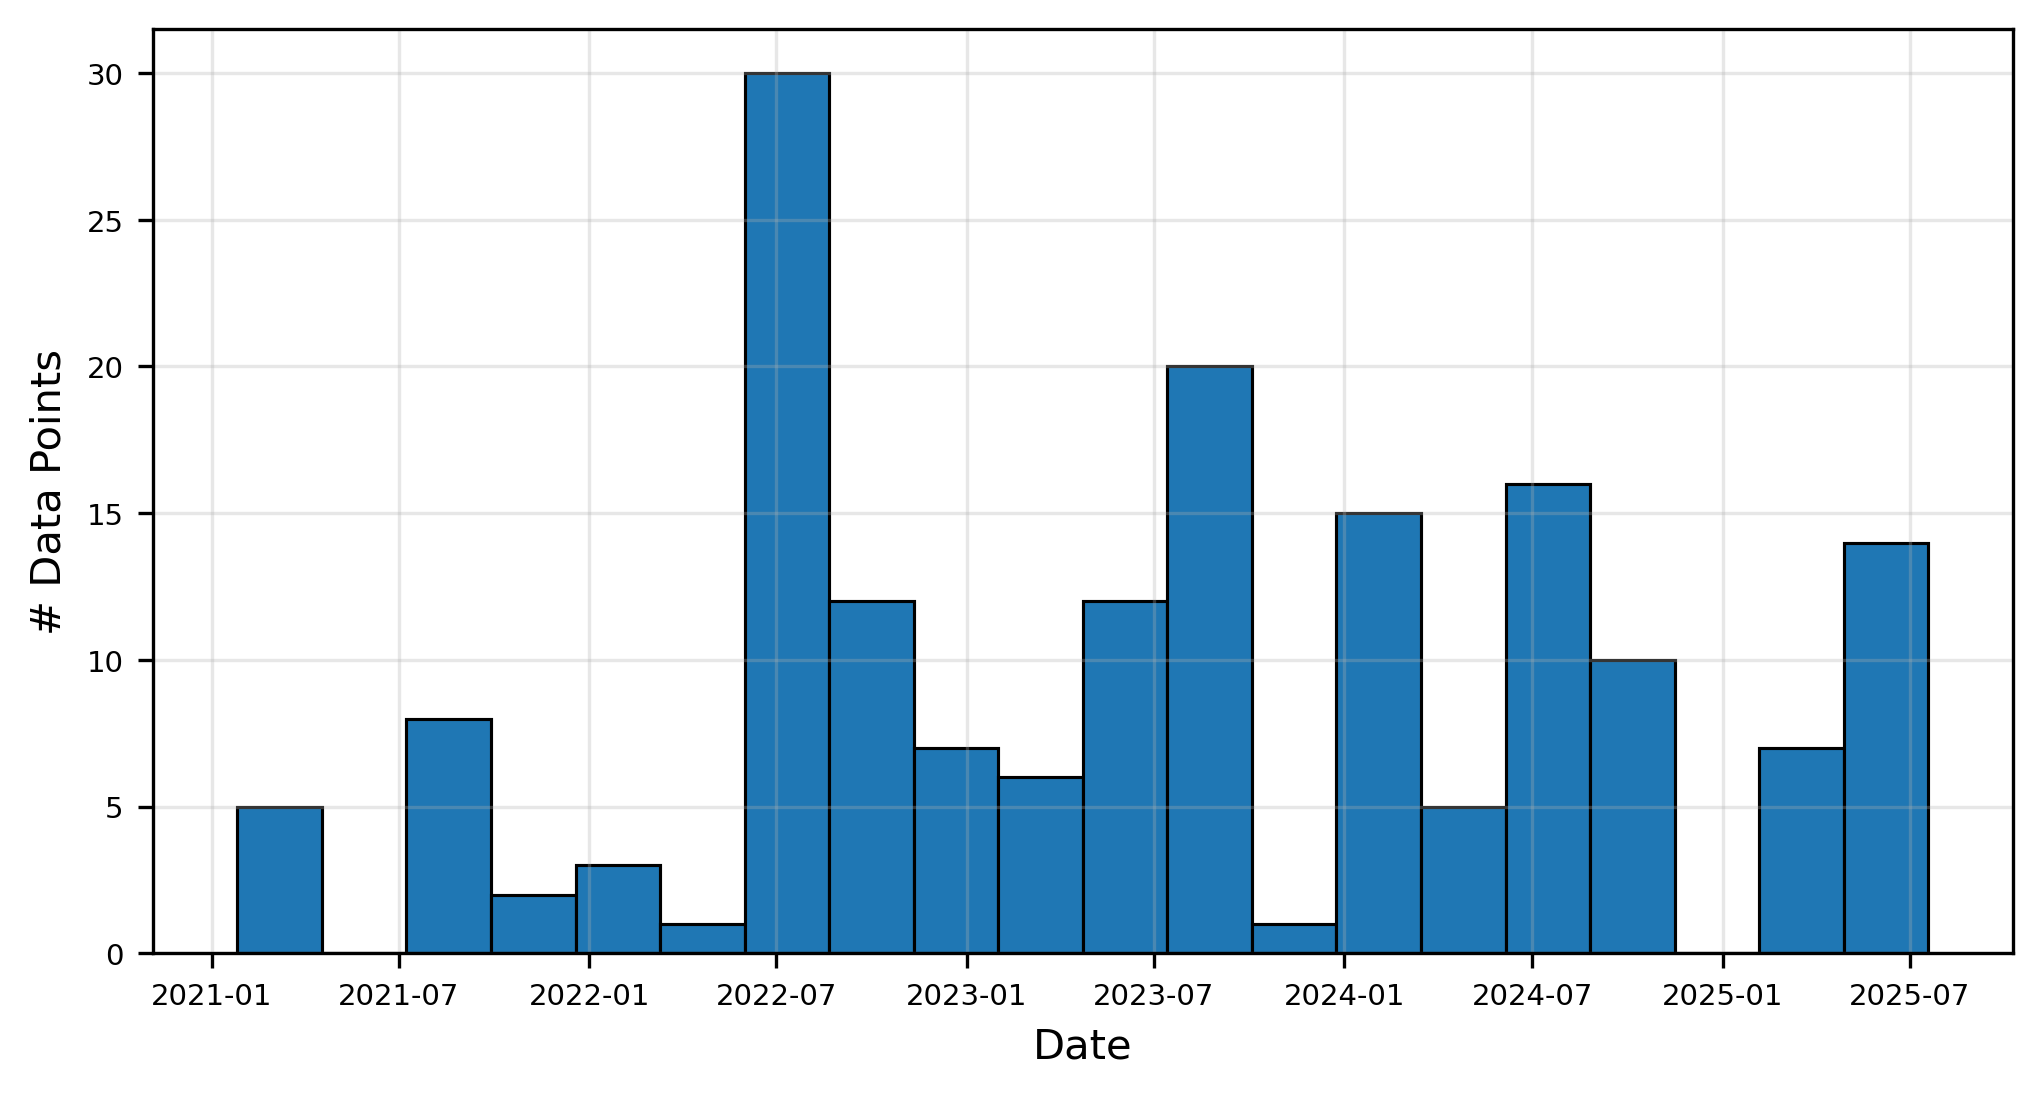

In [192]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

#### 1.2. Distribution of `mrms_qpe` by Seasonality

In [109]:
df["start_time"] = pd.to_datetime(df["start_time"])
months = df["start_time"].dt.month

all_values = []
for i in range(1, 13):
    mask       = months.between(i, i)
    delta_qpes = df.loc[mask, "mrms_qpe"].tolist()
    all_values.append(delta_qpes)

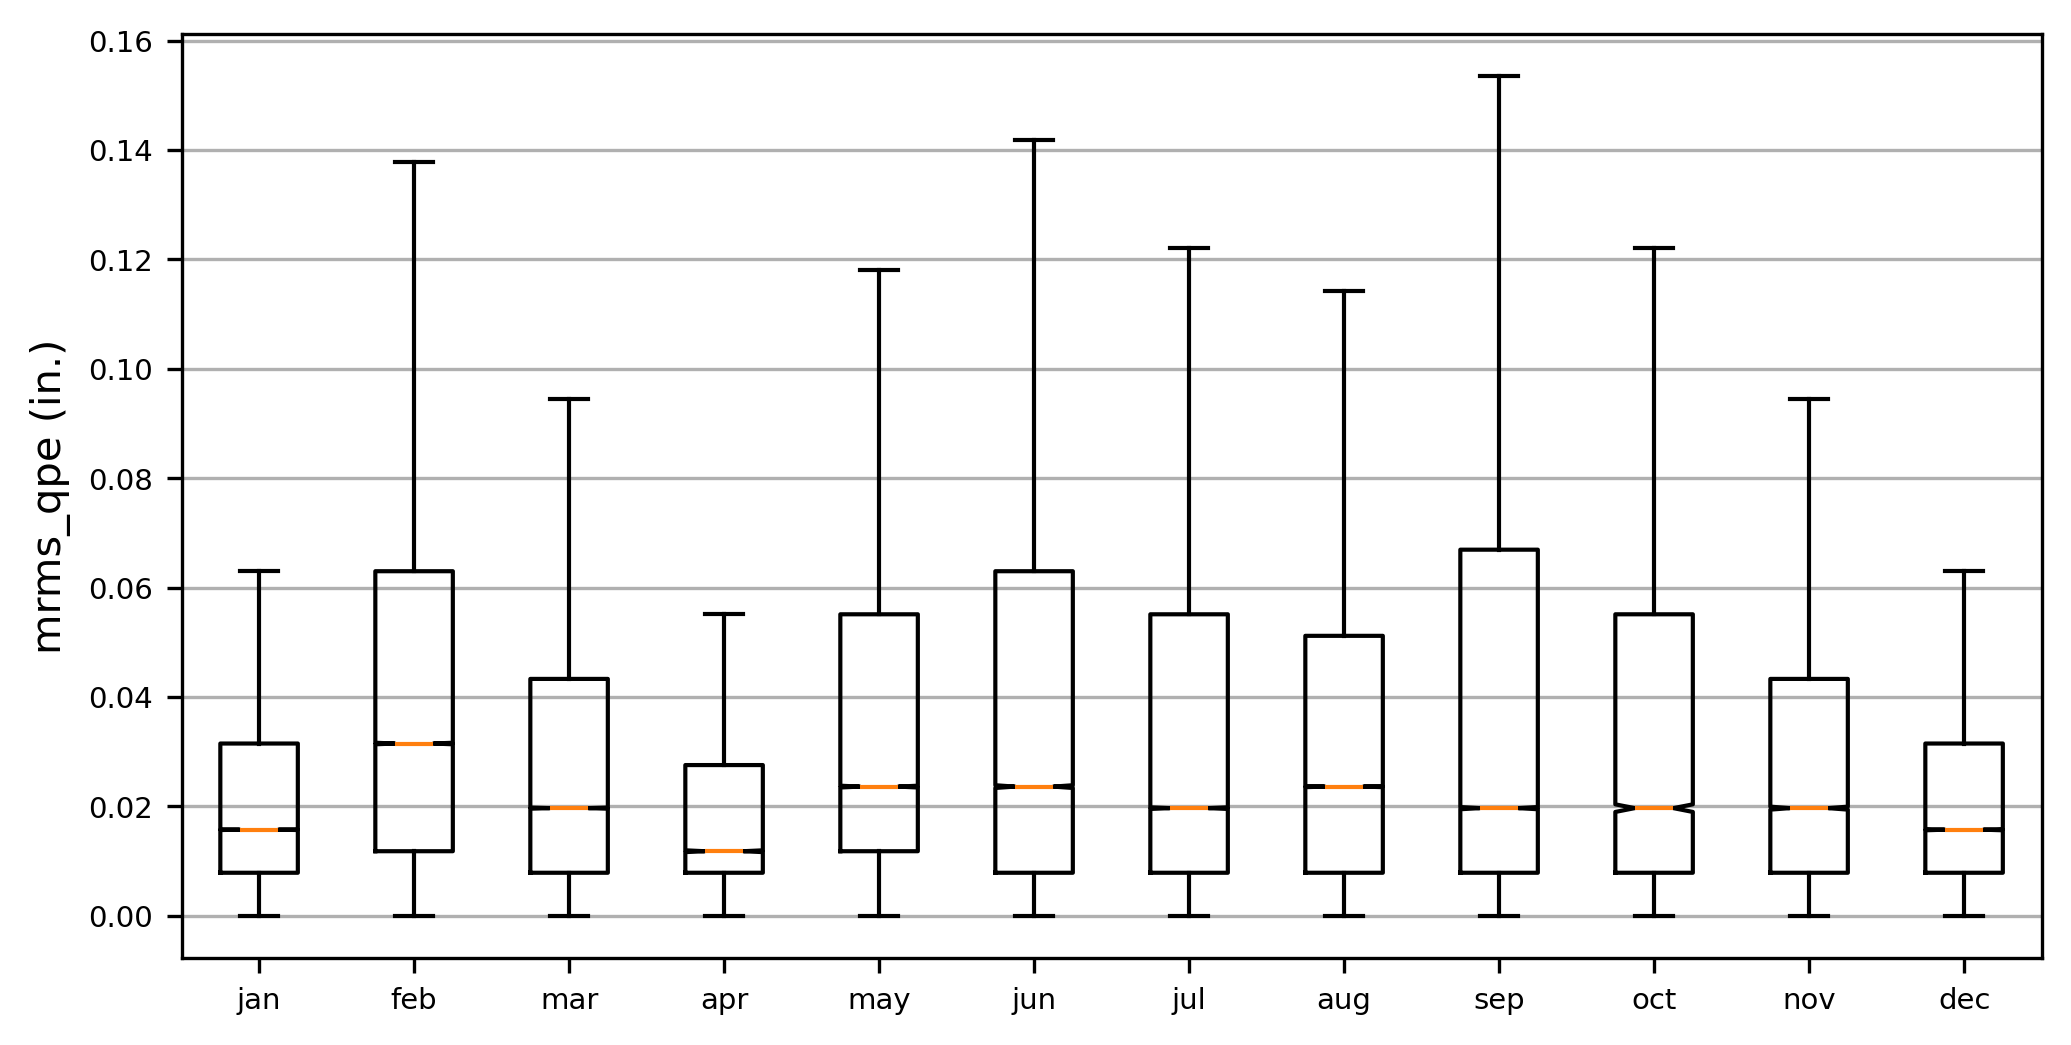

In [116]:
fig, axs = plt.subplots(figsize=(8, 4), dpi=300)
axs.boxplot(
    all_values,
    notch=True,
    showfliers=False,
    )

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(12)],
                  labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("mrms_qpe (in.)")
plt.show()

### 2. Per-Event Analysis

#### 2.1. Constructing Synthetic Rainfall "Events"

- As collected, our raw data do not have any meaningful metadata attached to delinate unique rain fall events. In the following section, we create synthetic "events" so that we can analyize the performance of rain-gauges over time.

In [145]:
# cummulative sum of all MRMS values at all gauges for each unique timestep
grouped_df   = df[['start_time', 'mrms_qpe']].groupby('start_time').sum().copy()
cum_mrms_qpe = grouped_df['mrms_qpe']

series = np.asarray(list(cum_mrms_qpe))

# lower bound of cummulative precip considered to be a "dry" period
p50    = np.percentile(series, 50)
print(f"50th percentile cummulative precip.: {p50}")


def segment_rainfall_events(
        precip_array, 
        interval_minutes=2, 
        wet_period_mins=60, 
        dry_period_mins=120, 
        rain_threshold=p50,
    ) -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: Columns include 'precipitation' and 'is_event' (bool).
    """
    precip_series = pd.Series(precip_array)
    is_rain = (precip_series > rain_threshold).astype(int)

    wet_period_intervals = wet_period_mins // interval_minutes
    dry_period_intervals = dry_period_mins // interval_minutes
    
    rolling_wet = is_rain.rolling(window=wet_period_intervals, min_periods=wet_period_intervals).sum()
    valid_wet_start = (rolling_wet == wet_period_intervals)

    rolling_dry = is_rain.rolling(window=dry_period_intervals, min_periods=dry_period_intervals).sum()
    valid_dry_end = (rolling_dry == 0)

    is_event = np.zeros_like(is_rain, dtype=bool)

    in_event = False
    start_idx = 0

    for i in range(len(is_rain)):
        if not in_event:

            # Wait until a valid wet period starts
            if valid_wet_start.iloc[i]:
                in_event = True
                start_idx = i - wet_period_intervals + 1  # start of rain
        else:
            
            # If inside an event, check for a valid dry period to end the event
            if valid_dry_end.iloc[i]:
                end_idx = i - dry_period_intervals + 1
                is_event[start_idx:end_idx] = True
                in_event = False

    if in_event:
        is_event[start_idx:] = True

    return pd.DataFrame({
        'precipitation': precip_series,
        'is_event': is_event
    })


rainfall_events = segment_rainfall_events(series)

50th percentile cummulative precip.: 0.1456692926585671


In [146]:
grouped_df['is_event'] = list(rainfall_events['is_event'])

curr_id   = -1
flag      = False
event_ids = []

for is_event in list(grouped_df['is_event']):
    
    if is_event == True:
        if flag == False:
            curr_id += 1
            flag = True
    else:
        flag = False
        
    event_ids.append(curr_id if is_event else np.nan)

# map unique datetime objects to rainfall event ids
grouped_df['event_id'] = event_ids
event_ids_mapped       = {dt: event_id for dt, event_id in zip(list(grouped_df.index), list(grouped_df['event_id']))}

In [187]:
event_ids      = [event_ids_mapped[k] for k in list(df['start_time'])]
df['event_id'] = event_ids
df_rain_events = df.loc[df['event_id'] > 0.0]

print(f"# Data points for rain events: {len(df_rain_events)}")
print(f"# Unique events: {len(set(df_rain_events['event_id']))}")

# ~2.2M data points from rain "events"
df_rain_events.head()

# Data points for rain events: 2221909
# Unique events: 174


,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,cum_gauge_qpe,cum_mrms_qpe,event_id
2562,2021-01-25 23:00:00,2021-01-26 00:00:00,4504,36.225833,244.673917,0.0,0.062992,-0.062992,0.0,0.062992,1.0
2563,2021-01-25 23:00:00,2021-01-26 00:00:00,3844,36.239361,244.441083,0.0,0.023622,-0.023622,0.0,0.748032,1.0
2564,2021-01-25 23:00:00,2021-01-26 00:00:00,4074,36.195833,244.901389,0.0,0.007874,-0.007874,0.0,0.212598,1.0
2565,2021-01-25 23:00:00,2021-01-26 00:00:00,4384,36.130694,244.835528,0.0,0.011811,-0.011811,0.0,0.011811,1.0
2566,2021-01-25 23:00:00,2021-01-26 00:00:00,4289,36.155764,244.837406,0.0,0.011811,-0.011811,0.0,0.110236,1.0


#### 2.2. Rain-Event Statistics

In [190]:
# create a list of `start_time` for each unique rain event
unique_events = df_rain_events.drop_duplicates(subset="event_id")
dts           = pd.to_datetime(unique_events["start_time"]).tolist()

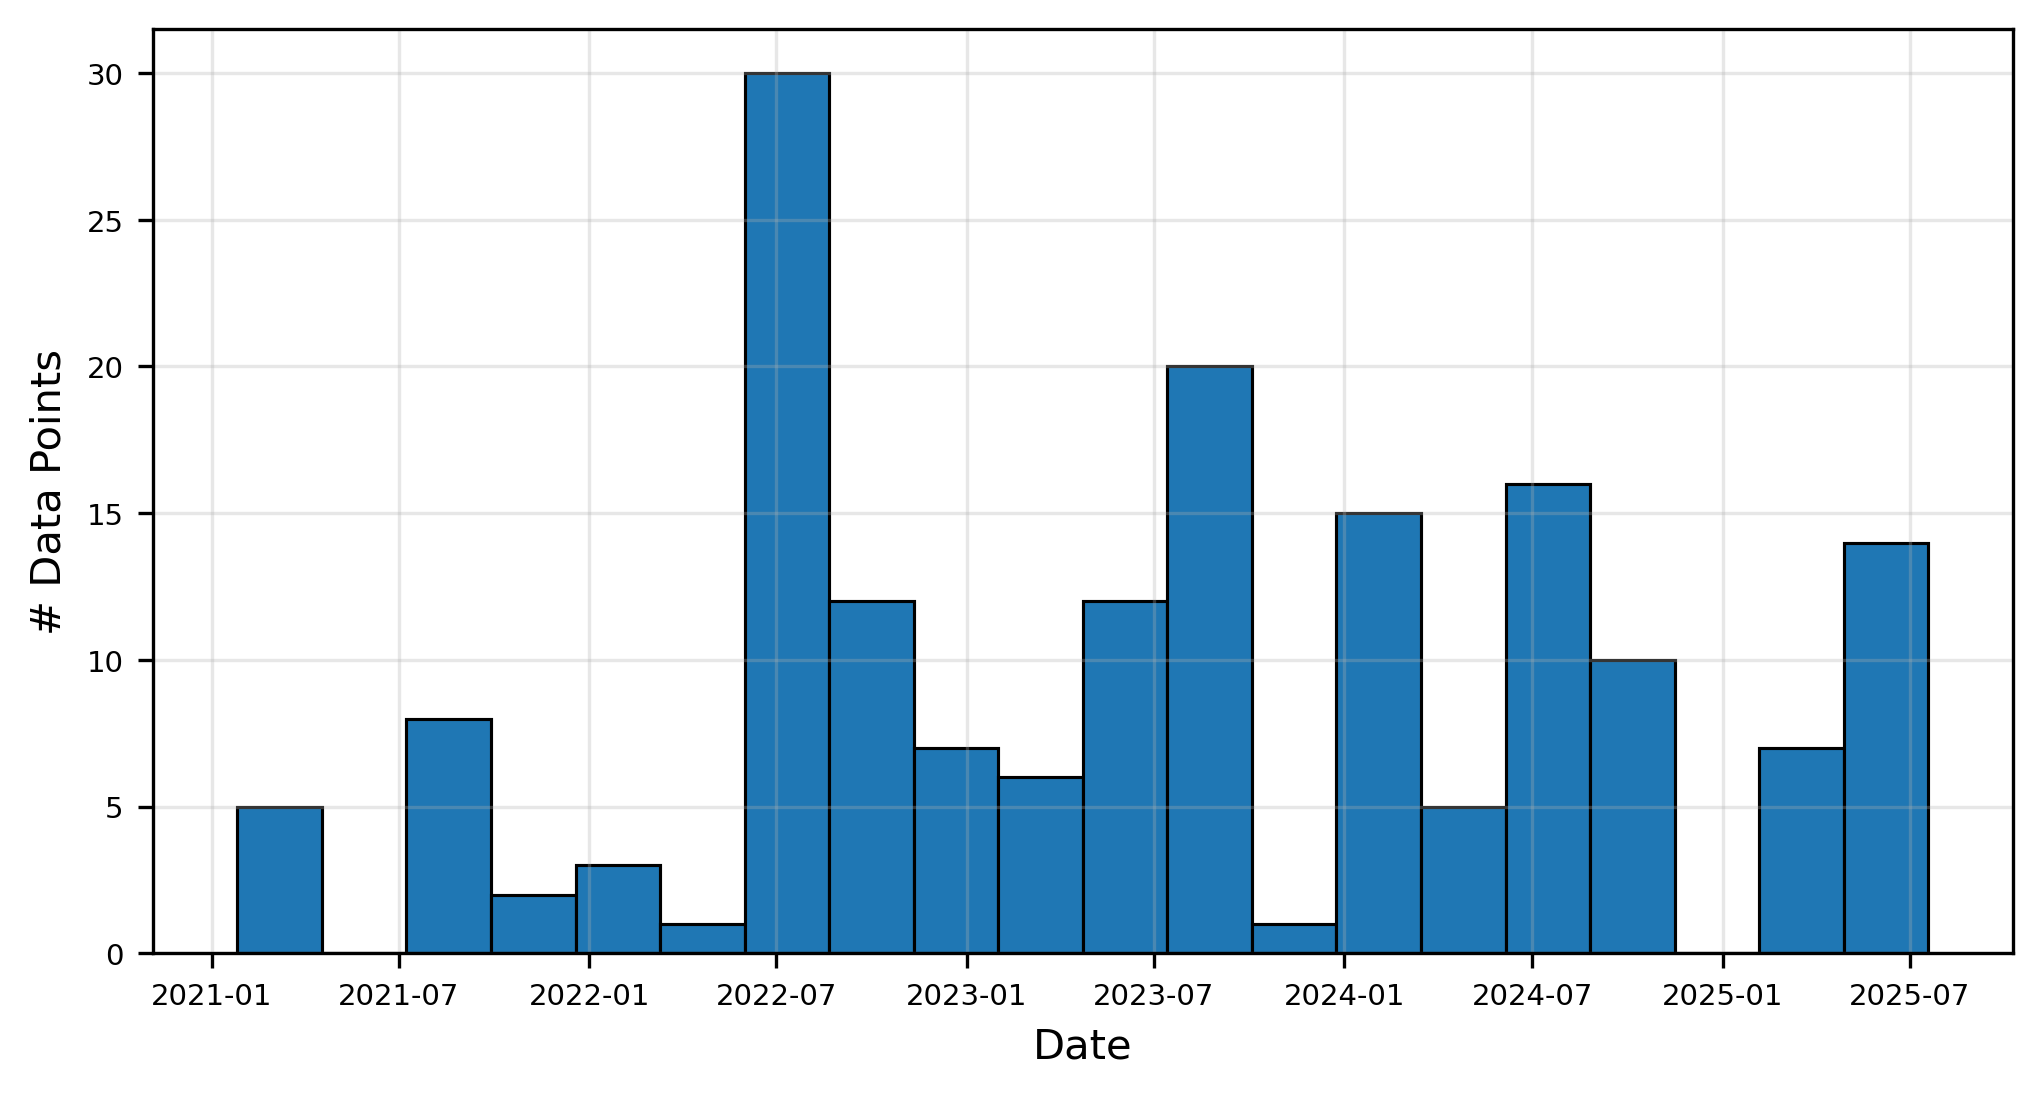

In [191]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

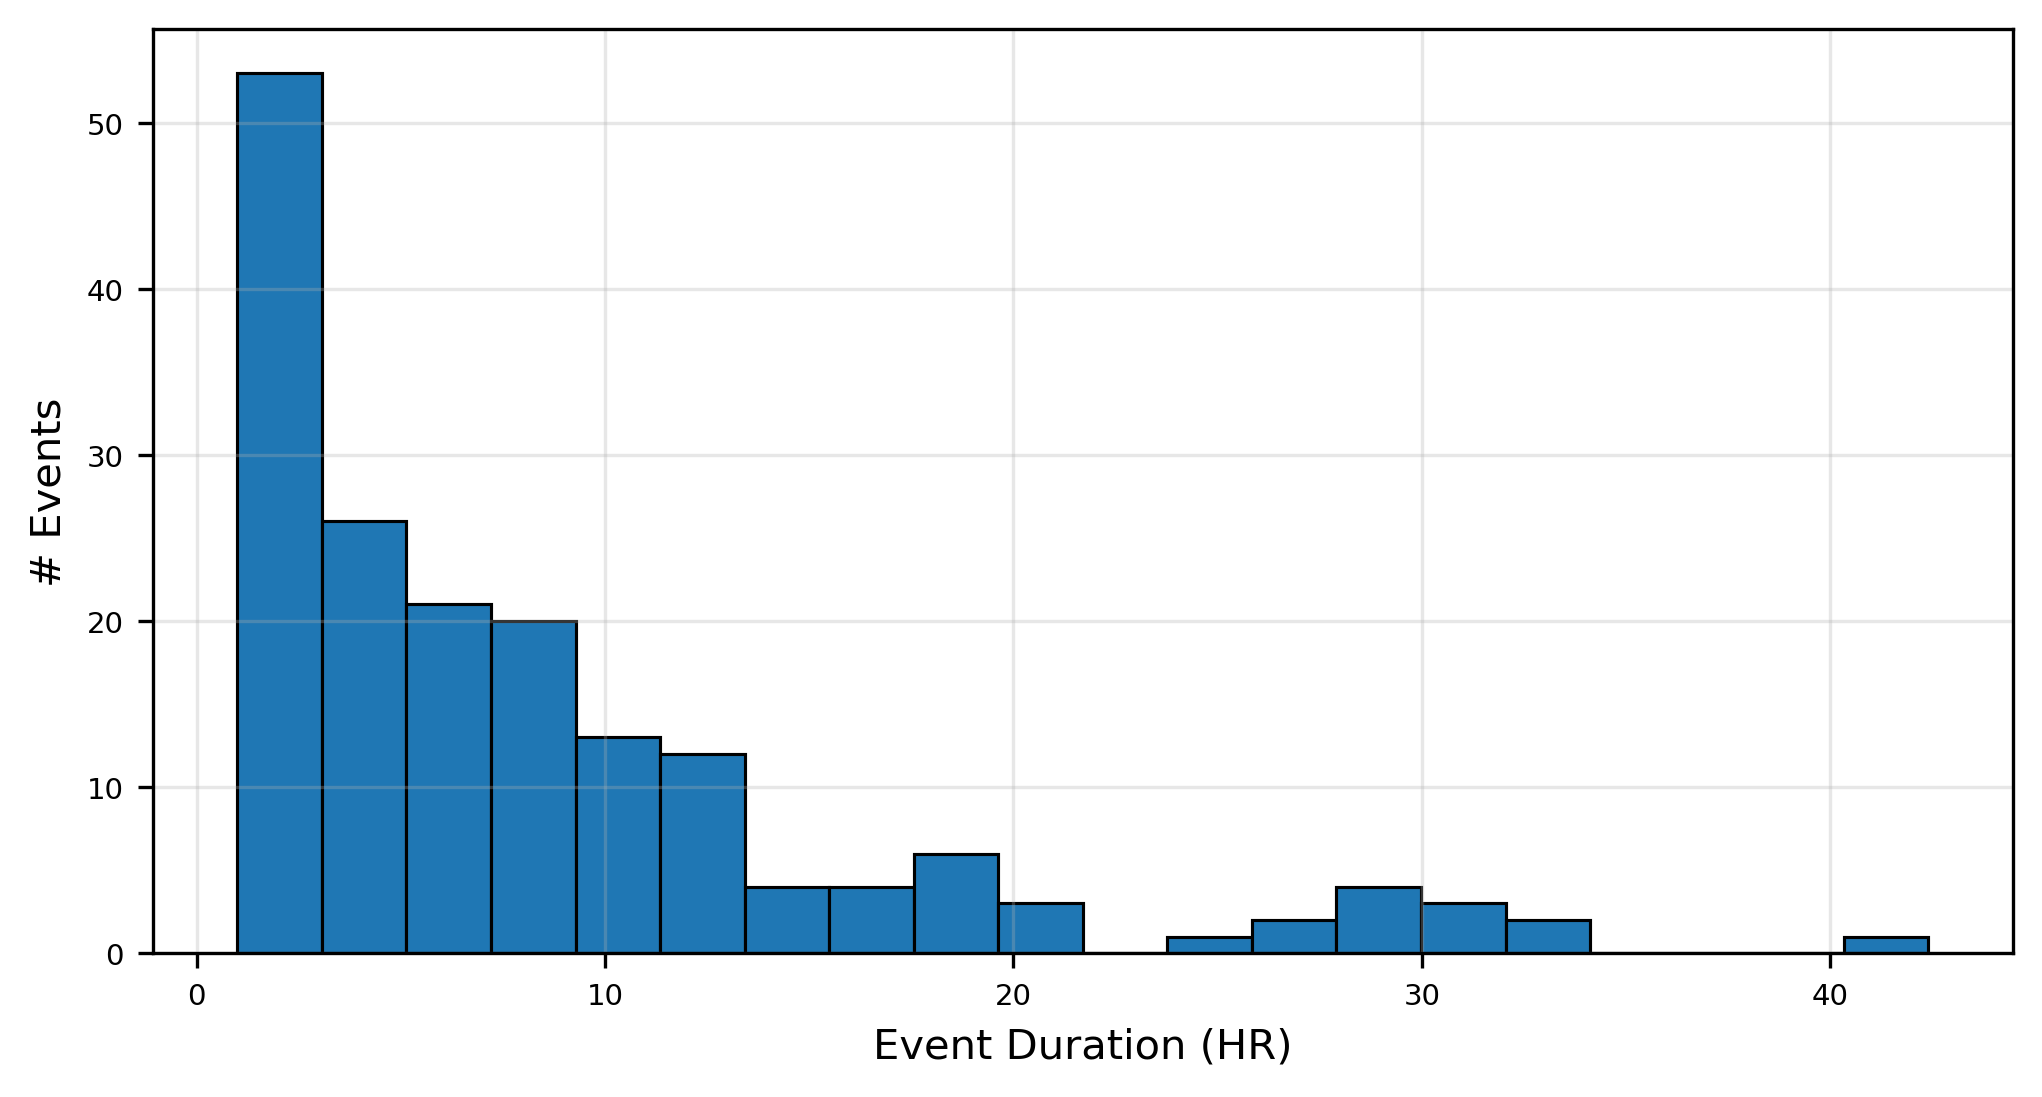

In [185]:
# a bit of a hack to grab the duration of each event
durations = grouped_df.groupby('event_id').count()['mrms_qpe']

# 2 min. buckets -> hrs
hr_durations = durations * (1/30)

fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(hr_durations, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Event Duration (HR)")
plt.xticks(fontsize=7)
plt.ylabel("# Events")
plt.yticks(fontsize=7)
plt.show()

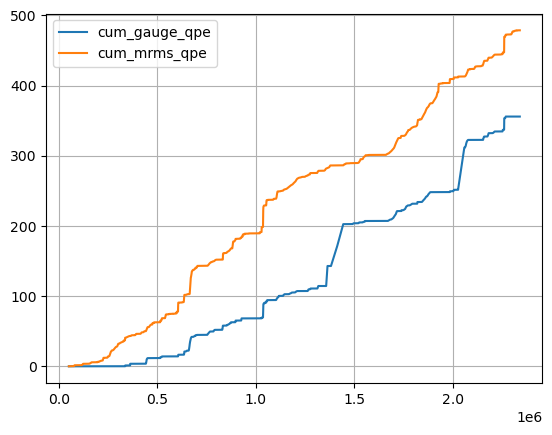

In [114]:
station_four  = df.loc[df['station_id'] == 4]
cum_gauge_qpe = station_four['cum_gauge_qpe']
cum_mrms_qpe  = station_four['cum_mrms_qpe']

plt.plot(cum_gauge_qpe, label="cum_gauge_qpe")
plt.plot(cum_mrms_qpe,  label="cum_mrms_qpe")
plt.grid()
plt.legend()
plt.show();

In [115]:
segment_rainfall_events(cum_mrms_qpe)

,precipitation,is_event
50696,0.003937,False
50890,0.007874,False
50950,0.011811,False
51193,0.015748,False
51426,0.019685,False
...,...,...
2339224,478.685044,True
2339252,478.688981,True
2339319,478.692918,True
2339390,478.696855,True


In [116]:
data = cum_mrms_by_time
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'cum_mrms_by_time' is not defined

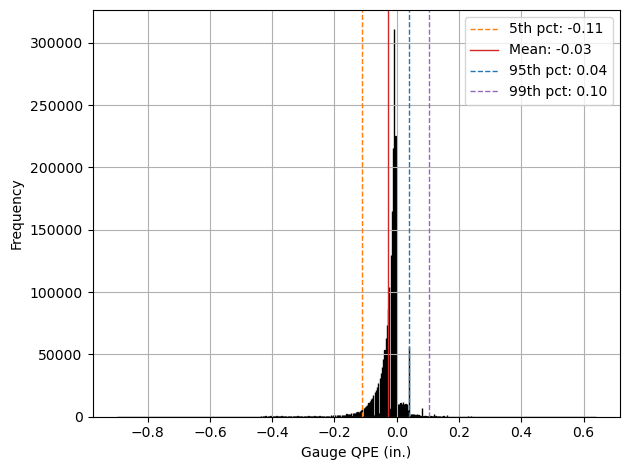

In [ ]:
data = df['delta_qpe']
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

### 3. Enviornmental Analysis

#### 3.1. Major Correlates of `delta_qpe`